In [ ]:
import os
os.chdir('scripts')

In [119]:
import random

In [120]:
import argparse
import os

import numpy as np
import torch as th
import torch
import torch.distributed as dist
import torch.nn.functional as F

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util_x0 import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

from guided_diffusion.dataloader import F3Dataset

from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import cv2
import pdb
from piq import ssim, psnr

In [121]:
deg = 'inp'
image_size = 128
channels = 1
device = 'cuda:0'
use_fp16 = True
H_funcs = None
use_ddim = False

In [127]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(device)
device = th.device('cuda')
logger.log("creating model and diffusion...")
model_path = "/poc-data/pvn/model/diffusion/GenerativeDiffusionPrior/results/ckpt/ema_0.9999_150000.pt"
dist_util.setup_dist()

model_params = dict(
    image_size=128,
    num_channels=128,
    num_res_blocks=2,
    num_heads=4,
    num_heads_upsample=-1,
    num_head_channels=64,
    attention_resolutions="32,16,8",
    channel_mult="",
    dropout=0.0,
    class_cond=False,
    use_checkpoint=False,
    use_scale_shift_norm=True,
    resblock_updown=True,
    use_fp16=True,
    use_new_attention_order=False,
    learn_sigma=True,
    diffusion_steps=1000,
    noise_schedule="cosine",
    timestep_respacing="",
    use_kl=False,
    predict_xstart=False,
    rescale_timesteps=False,
    rescale_learned_sigmas=False
)

model, diffusion = create_model_and_diffusion(**model_params)
model.load_state_dict(
    th.load(model_path, map_location="cpu")
)
model.to(dist_util.dev())
# model.to(device)
if use_fp16:
    model.convert_to_fp16()
model.eval()
print('Number parameters: ', sum(p.numel() for p in model.parameters()))

creating model and diffusion...
Number parameters:  105191682


In [128]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [129]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

def p_sample_loop(
        model,
        shape,
        num_display_steps,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        denoise_steps=None
    ):
    
    final = None
    indices = list(np.linspace(0, diffusion.num_timesteps - 1, num_display_steps).astype(np.int64))[::-1]

    i = 0
    display_by_steps = []
    noise_by_steps = []
    
    for sample in diffusion.p_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
            denoise_steps=denoise_steps
        ):
        if (i in indices):
            display_by_steps.append(sample['pred_xstart'])
            noise_by_steps.append(sample['sample'])
        i += 1
        final = sample
    return th.stack(display_by_steps), th.stack(noise_by_steps), final['sample']

In [130]:
def discrete_missing(data, proportion):
    mask = th.ones(data.shape)
    for i in range(data.shape[0]):
        sample = random.sample(range(1, image_size), int((image_size - 1) * proportion))
        for j in sample:
            mask[i, :, :, j] = 0
    return mask

In [131]:
def general_cond_fn(x, t, y=None, x_lr=None, sample_noisy_x_lr=False, diffusion=None, sample_noisy_x_lr_t_thred=None):
#     assert y is not None
    with th.enable_grad():
        x_in = x.detach().requires_grad_(True)
        if not x_lr is None:  
            x_in_tmp = H_funcs.H(((x_in+1)/2).to(th.float32))
            x_in_lr = H_funcs.H_pinv(x_in_tmp).view(x_in_tmp.shape[0], channels, image_size, image_size)
        
            x_in_lr.to(th.uint8)
            
            if sample_noisy_x_lr:
                t_numpy = t.detach().cpu().numpy()
                spaced_t_steps = [diffusion.timestep_reverse_map[t_step] for t_step in t_numpy]
                if sample_noisy_x_lr_t_thred is None or spaced_t_steps[0] < sample_noisy_x_lr_t_thred:
#                     print('Sampling noisy lr')
                    spaced_t_steps = th.Tensor(spaced_t_steps).to(t.device).to(t.dtype)
                    x_lr = diffusion.q_sample(x_lr, spaced_t_steps)

            x_lr = (x_lr + 1) / 2
            mse = (x_in_lr - x_lr) ** 2
            mse = mse.mean(dim=(1,2,3))
            mse = mse.sum()
#             ssim_value = pytorch_ssim.ssim(x_in_lr, x_lr).item()
#             ssim_loss = pytorch_ssim.SSIM()
#             ssim_out = -ssim_loss(x_in_lr, x_lr)

            loss = - mse * img_guidance_scale # move xt toward the gradient direction 
#             print('step t %d img guidance has been used, mse is %.8f * %d = %.2f' % (t[0], mse, img_guidance_scale, mse*img_guidance_scale))
        return th.autograd.grad(loss, x_in)[0]

In [132]:
def model_fn(x, t, y=None):
    return model(x, t)
cond_fn = lambda x,t : general_cond_fn(x, t, x_lr=image_lr, sample_noisy_x_lr=True, diffusion=diffusion, sample_noisy_x_lr_t_thred=1e8)

In [133]:
ds = F3Dataset("/poc-data/pvn/data/F3", mode='test')
batch_size = 16
dataset = th.utils.data.DataLoader(
                                ds,
                                batch_size=batch_size,
                                shuffle=False)

Number data: 16012


In [134]:
def mask_inpainting(x):
    x_tmp = H_funcs.H(((x+1)/2).to(th.float32))
    x_masked = H_funcs.H_pinv(x_tmp).view(x_tmp.shape[0], channels, image_size, image_size)
    x_masked = x_masked * 2 - 1
    return x_masked

In [135]:
def visualize(sample):
    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    return sample.cpu()

In [136]:
from functions.svd_replacement import Inpainting
mask = th.ones((image_size, image_size))
proportion = 0.4
sample = random.sample(range(1, image_size), int((image_size - 1) * proportion))
for j in sample:
    mask[:, j] = 0
spatial_mask = mask
mask = mask.reshape(-1)
missing = th.nonzero(mask == 0).long().reshape(-1)
H_funcs = Inpainting(channels, image_size, missing, device)

In [137]:
def normalize(image):
    """Basic min max scaler.
    """
    image = image / 255
    return image
def snr_(gt, pred):
    snr_score = 10*np.log10(np.sum(pred**2)/np.sum((pred-gt)**2))
    return snr_score
    
def get_metric(gt, pred):
    gt = normalize(gt.unsqueeze(0).permute(0, 3, 1, 2))
    pred = normalize(pred.unsqueeze(0).permute(0, 3, 1, 2))
    ssim_score = ssim(gt, pred)
    psnr_score = psnr(gt, pred)
    snr_score = snr_(gt[0].numpy(), pred[0].numpy())
    return ssim_score, psnr_score, snr_score

In [138]:
def show(imgs, cmap):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fix.set_figwidth(24)
    fix.set_figheight(100)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = img.numpy()
        axs[0, i].imshow(np.asarray(img), cmap=cmap)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [139]:
img_guidance_scale = 3000

In [140]:
for img in dataset:
    if th.cuda.is_available():
        img[0] = th.Tensor(img[0]).cuda()
    model_kwargs = {}
    sample_fn = (
        p_sample_loop if not use_ddim else diffusion.ddim_sample_loop
    )
    shape = img[0].shape
    image_lr = mask_inpainting(img[0])
    grid, noise, sample = sample_fn(
            model_fn,
            shape,
            num_display_steps=10,
            clip_denoised=True,
            model_kwargs=model_kwargs,
            cond_fn=cond_fn,
            device=device,
            progress=True
        )
    original = visualize(img[0])
    masked_image = visualize(image_lr)
    sample = visualize(sample)
    ssim_scores = []
    psnr_scores = []
    snr_scores = []
    # spatial_mask = spatial_mask.unsqueeze(0).unsqueeze(3)
    # final = sample * (1 - spatial_mask) + original * spatial_mask
    for i in range(batch_size):
        ssim_score, psnr_score, snr_score = get_metric(original[i], sample[i])
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        snr_scores.append(snr_score)
    metrics = zip(ssim_scores, psnr_scores, snr_scores)
    for i, v in enumerate(metrics):
        print(f"{i}: SSIM: {v[0]} - PSNR: {v[1]} - SNR: {v[2]}")
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

0: SSIM: 0.7639299631118774 - PSNR: 24.411088943481445 - SNR: 18.56993556022644
1: SSIM: 0.7849181890487671 - PSNR: 24.894771575927734 - SNR: 19.08512234687805
2: SSIM: 0.7983829975128174 - PSNR: 24.826248168945312 - SNR: 19.03557538986206
3: SSIM: 0.7490643858909607 - PSNR: 25.688907623291016 - SNR: 19.770560264587402
4: SSIM: 0.738713264465332 - PSNR: 24.943836212158203 - SNR: 19.056466817855835
5: SSIM: 0.7459423542022705 - PSNR: 25.072553634643555 - SNR: 19.20844316482544
6: SSIM: 0.7441658973693848 - PSNR: 25.145801544189453 - SNR: 19.250560998916626
7: SSIM: 0.7352443337440491 - PSNR: 26.33049964904785 - SNR: 20.40470838546753
8: SSIM: 0.7332161664962769 - PSNR: 26.569250106811523 - SNR: 20.608351230621338
9: SSIM: 0.7376732230186462 - PSNR: 23.92399787902832 - SNR: 18.070623874664307
10: SSIM: 0.7493562698364258 - PSNR: 25.27167510986328 - SNR: 19.461584091186523
11: SSIM: 0.7750191688537598 - PSNR: 26.000076293945312 - SNR: 20.2541446685791
12: SSIM: 0.7670322060585022 - PSNR: 

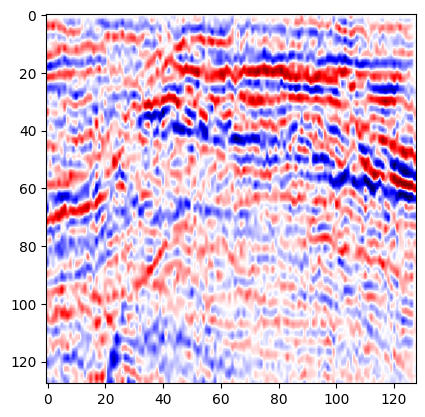

In [141]:
plt.imshow(sample[0].cpu(), cmap=plt.cm.seismic)

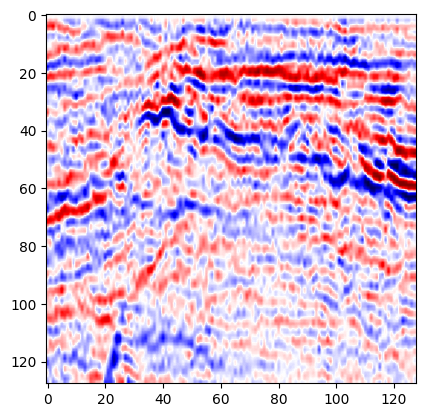

In [102]:
plt.imshow(original[0].cpu(), cmap=plt.cm.seismic)

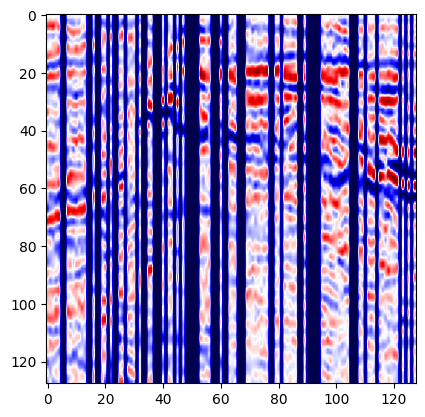

In [86]:
plt.imshow(masked_image[0].cpu(), cmap=plt.cm.seismic)

In [217]:
def show(imgs, cmap):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fix.set_figwidth(24)
    fix.set_figheight(100)
    for i, img in enumerate(imgs):
        img = img.detach()
        print(img.shape)
        # img = F.to_pil_image(img)
        # axs[0, i].imshow(np.asarray(img), cmap=cmap)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400')])

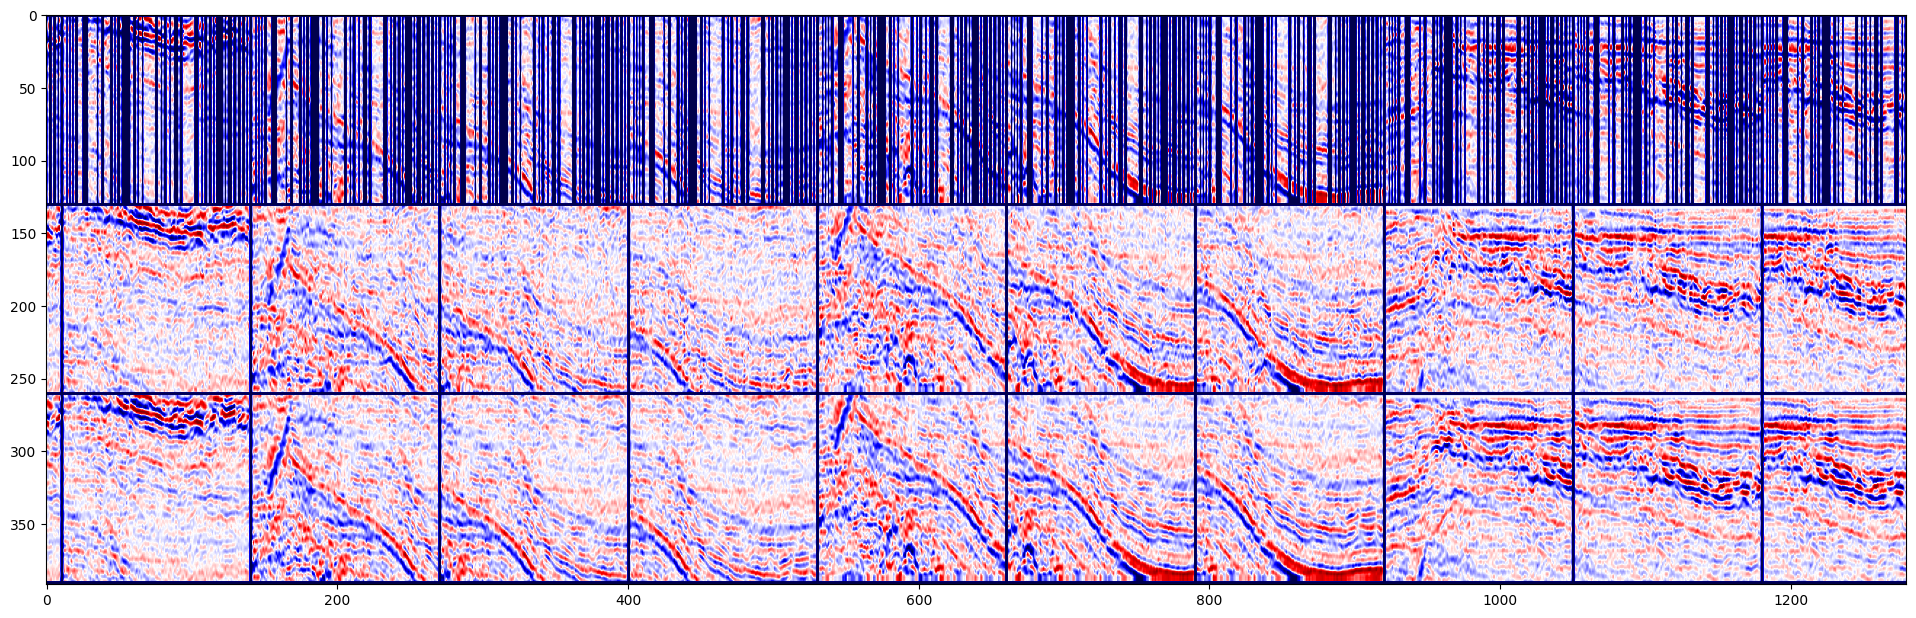

In [241]:
grid_samples = th.concat([masked_image, sample, original], dim=0)
grid_samples = grid_samples.permute(0, 3, 1, 2)
grid = make_grid(grid_samples, batch_size)
plt.figure(figsize=(24, batch_size*8))
start_img = 5
end_img = 15
plt.imshow(grid[0][:, start_img*128:end_img*128], cmap=plt.cm.seismic)
plt.xticks()
plt.yticks()

In [143]:
from abc import ABC, abstractmethod
import torch

class ConditioningMethod(ABC):
    def __init__(self, operator, noiser, **kwargs):
        self.operator = operator
        self.noiser = noiser
    
    def project(self, data, noisy_measurement, **kwargs):
        return self.operator.project(data=data, measurement=noisy_measurement, **kwargs)
    
    def grad_and_value(self, x_prev, x_0_hat, measurement, **kwargs):
#         if self.noiser.__name__ == 'gaussian':
        difference = measurement - self.operator.forward(x_0_hat, **kwargs)
        norm = torch.linalg.norm(difference)
        norm_grad = torch.autograd.grad(outputs=norm, inputs=x_prev)[0]
        
#         elif self.noiser.__name__ == 'poisson':
#             Ax = self.operator.forward(x_0_hat, **kwargs)
#             difference = measurement-Ax
#             norm = torch.linalg.norm(difference) / measurement.abs()
#             norm = norm.mean()
#             norm_grad = torch.autograd.grad(outputs=norm, inputs=x_prev)[0]

#         else:
#             raise NotImplementedError
             
        return norm_grad, norm
   
    @abstractmethod
    def conditioning(self, x_t, measurement, noisy_measurement=None, **kwargs):
        pass


class PosteriorSampling(ConditioningMethod):
    def __init__(self, operator, noiser, **kwargs):
        super().__init__(operator, noiser)
        self.scale = kwargs.get('scale', 1.0)

    def conditioning(self, x_prev, x_t, x_0_hat, measurement, **kwargs):
        norm_grad, norm = self.grad_and_value(x_prev=x_prev, x_0_hat=x_0_hat, measurement=measurement, **kwargs)
        x_t -= norm_grad * self.scale
        return x_t, norm

class LinearOperator(ABC):
    @abstractmethod
    def forward(self, data, **kwargs):
        # calculate A * X
        pass

    @abstractmethod
    def transpose(self, data, **kwargs):
        # calculate A^T * X
        pass
    
    def ortho_project(self, data, **kwargs):
        # calculate (I - A^T * A)X
        return data - self.transpose(self.forward(data, **kwargs), **kwargs)

    def project(self, data, measurement, **kwargs):
        # calculate (I - A^T * A)Y - AX
        return self.ortho_project(measurement, **kwargs) - self.forward(data, **kwargs)

class InpaintingOperator(LinearOperator):
    '''This operator get pre-defined mask and return masked image.'''
    def __init__(self, device):
        self.device = device
    
    def forward(self, data, **kwargs):
        try:
            return data * kwargs.get('mask', None).to(self.device)
        except:
            raise ValueError("Require mask")
    
    def transpose(self, data, **kwargs):
        return data
    
    def ortho_project(self, data, **kwargs):
        return data - self.forward(data, **kwargs)

class Noise(ABC):
    def __call__(self, data):
        return self.forward(data)
    
    @abstractmethod
    def forward(self, data):
        pass

class GaussianNoise(Noise):
    def __init__(self, sigma):
        self.sigma = sigma
    
    def forward(self, data):
        return data + torch.randn_like(data, device=data.device) * self.sigma

In [144]:
def p_sample_loop_dps(model,
                  shape,
                  measurement,
                  measurement_cond_fn):
        """
        The function used for sampling from noise.
        """ 
        device = next(model.parameters()).device
        img = th.randn(*shape, device=device)
        
        pbar = tqdm(list(range(diffusion.num_timesteps))[::-1])
        for idx in pbar:
            time = th.tensor([idx] * img.shape[0], device=device)
            
            img = img.requires_grad_()
           
            out = diffusion.p_sample(model, img, time)
            
            # Give condition.
            noisy_measurement = diffusion.q_sample(measurement, time)

            # TODO: how can we handle argument for different condition method?
            img, distance = measurement_cond_fn(x_t=out['sample'],
                                      measurement=measurement,
                                      noisy_measurement=noisy_measurement,
                                      x_prev=img,
                                      x_0_hat=out['pred_xstart'])
            img = img.detach_()
           
            pbar.set_postfix({'distance': distance.item()}, refresh=False)

        return img       

In [175]:
from functools import partial
from tqdm.auto import tqdm
mask = spatial_mask.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
operator = InpaintingOperator(device=dist_util.dev())
noiser = GaussianNoise(sigma=0.01)
cond_method = PosteriorSampling(operator=operator, noiser=noiser, scale=1.5)
measurement_cond_fn = partial(cond_method.conditioning, mask=mask)

In [166]:
ds = F3Dataset("/poc-data/pvn/data/F3", mode='test')
batch_size = 16
dataset = th.utils.data.DataLoader(
                                ds,
                                batch_size=batch_size,
                                shuffle=False)

Number data: 16012


In [ ]:
for img in dataset:
    if th.cuda.is_available():
        img[0] = th.Tensor(img[0]).cuda()
    sample_fn = (
        p_sample_loop_dps if not use_ddim else diffusion.ddim_sample_loop
    )
    y = operator.forward(img[0], mask=mask)
    measurement = noiser(y)
    shape = img[0].shape
    sample = sample_fn(model,
                      shape,
                      measurement,
                      measurement_cond_fn)
    original = visualize(img[0])
    masked_image = visualize(image_lr)
    sample = visualize(sample)
    ssim_scores = []
    psnr_scores = []
    snr_scores = []
    # spatial_mask = spatial_mask.unsqueeze(0).unsqueeze(3)
    # final = sample * (1 - spatial_mask) + original * spatial_mask
    for i in range(batch_size):
        ssim_score, psnr_score, snr_score = get_metric(original[i], sample[i])
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        snr_scores.append(snr_score)
    metrics = zip(ssim_scores, psnr_scores, snr_scores)
    for i, v in enumerate(metrics):
        print(f"{i}: SSIM: {v[0]} - PSNR: {v[1]} - SNR: {v[2]}")
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

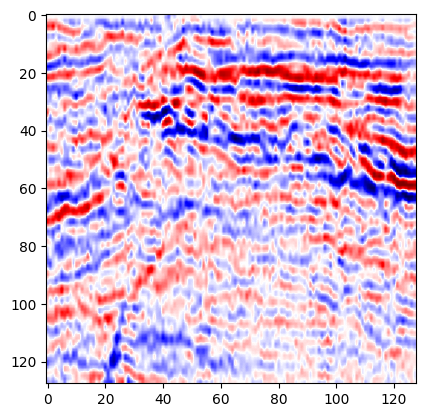

In [162]:
plt.imshow(sample[0].cpu(), cmap=plt.cm.seismic)

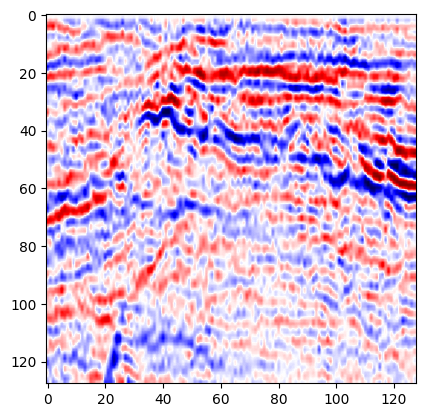

In [149]:
plt.imshow(original[0].cpu(), cmap=plt.cm.seismic)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400')])

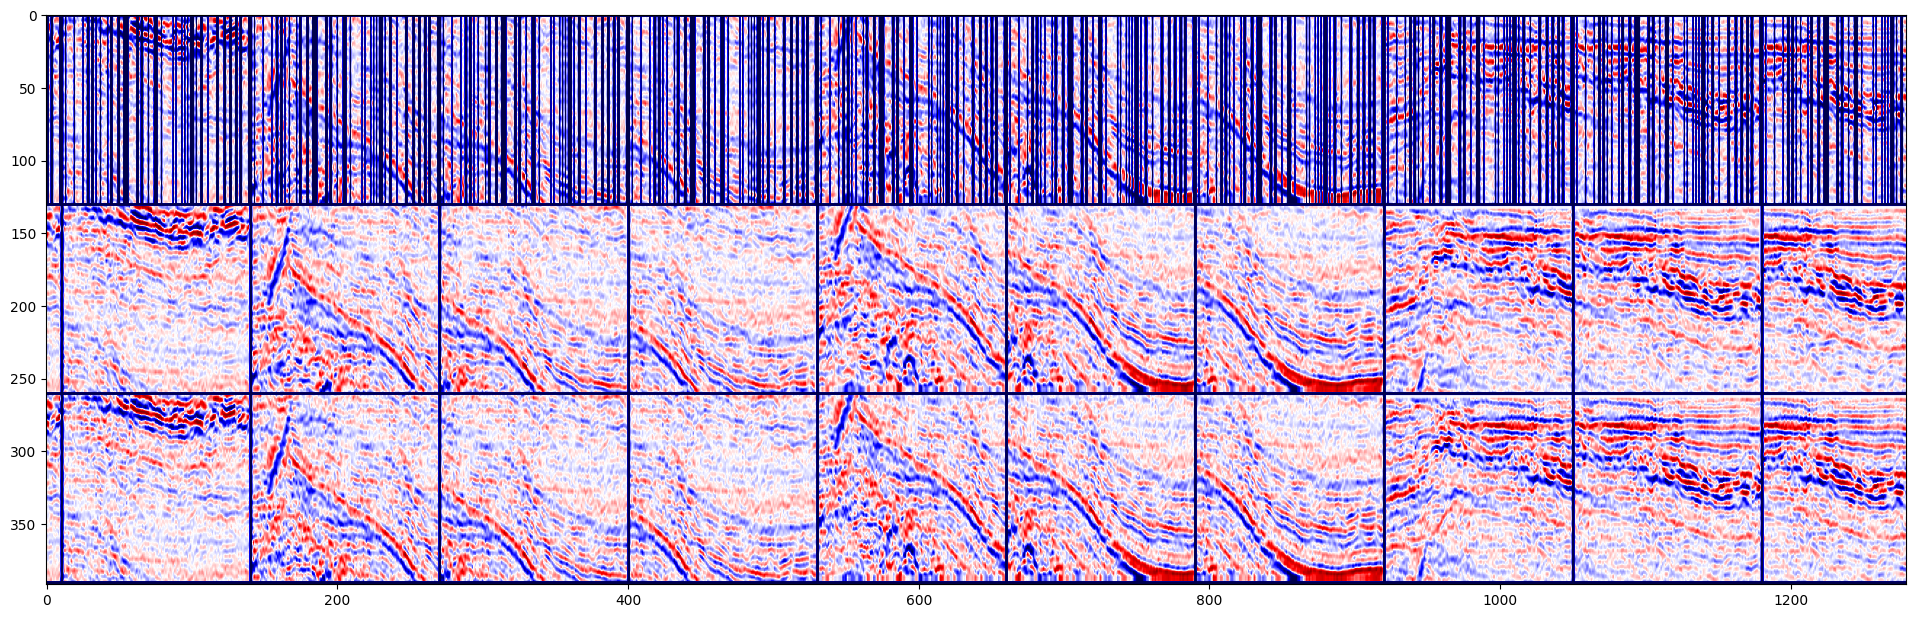

In [163]:
grid_samples = th.concat([masked_image, sample, original], dim=0)
grid_samples = grid_samples.permute(0, 3, 1, 2)
grid = make_grid(grid_samples, batch_size)
plt.figure(figsize=(24, batch_size*8))
start_img = 5
end_img = 15
plt.imshow(grid[0][:, start_img*128:end_img*128], cmap=plt.cm.seismic)
plt.xticks()
plt.yticks()